In [56]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json
from nltk import PorterStemmer, bigrams as nltk_bigrams
from nltk.tokenize import MWETokenizer
import nltk
import re
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache

sns.set_style("darkgrid")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

### Constants and function definitions

In [5]:
REVIEW_DATA_FILE = 'Movies_and_TV.jsonl'
META_DATA_FILE = "meta_Movies_and_TV.jsonl"

In [6]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

## 1. Data processing

### Process meta data

In [7]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

df_meta.limit(5)

title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Ben 10: Alien Force (Classic)""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [8]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("desc_len"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
)

best_per_title.limit(5)

title,asins,average_rating,rating_number,description,desc_len,price,categories,content_advisory
str,list[str],f64,i64,str,u32,f64,list[str],list[str]
"""The Wreck of the Hesperus""","[""B00KALQHQU""]",3.8,2,"""From the epic poem by Henry Wa…",494,12.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Action & Adventure""]",[]
"""This Is Your Life - The Ultima…","[""B00093GVWY""]",4.5,85,"""Product Description""",19,19.99,"[""Movies & TV"", ""Boxed Sets"", ""Television""]",[]
"""Candyman (1992)""","[""B07G2CJLKB""]",4.8,1760,"""This gut-wrenching thriller fo…",569,14.94,"[""Movies & TV"", ""Featured Categories"", … ""Horror""]",[]
"""Kaminey (Bollywood Movie / Ind…","[""B003VL2SPK""]",3.7,22,"""Review""",6,20.0,"[""Movies & TV"", ""Featured Categories"", … ""Foreign Films""]",[]
"""Dain Curse VHS""","[""B00004UG9I""]",3.8,78,"""To date, this is the most comp…",583,-1.0,"[""Movies & TV"", ""Boxed Sets"", ""Drama""]",[]


### Process review data

In [9]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
df.limit(5)

asin,user_id,text,rating,timestamp
str,str,str,f64,i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000
"""B000PIU2A0""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""this item was canceled. . . .n…",3.0,1556496429981
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000
"""B000TSMOEI""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""like watching: haven't gotten …",4.0,1364088147000
"""B0009MAO82""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""pretty cool to watch: differen…",4.0,1364087577000


In [10]:
df.height, df.get_column("asin").n_unique()

(2888210, 409673)

> All the asin with missing meta data

In [11]:
best_per_title.filter(pl.col("title").is_null()).get_column("asins")[0]

""
str
"""B0020EA54U"""
"""B01NA77W1Q"""
"""B000SVZITE"""
"""B083MY3P7R"""
"""B00RSI6HMW"""
…
"""B00HXT698S"""
"""B004J0G970"""
"""B00FJIRV7S"""


In [12]:
asin_title_map = best_per_title.select([
    pl.col("title"),
    pl.col("asins"),
    pl.col("average_rating"),
    pl.col("price")
]).explode("asins").rename({"asins": "asin"})

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

In [13]:
# df.get_column("asin").n_unique(), df_meta.get_column("parent_asin").n_unique()
# asins_in_df = df.get_column("asin").unique()
# asins_in_meta = df_meta.get_column("asin").unique()

# missing_asins = asins_in_df.filter(~asins_in_df.is_in(asins_in_meta.implode()))
# missing_asins.len()

In [14]:
# def filter_reviews(df, movie_threshold=5, review_threshold=5):
#     prev_rows = -1
#     while df.height != prev_rows:
#         prev_rows = df.height
#         valid_movies = (
#             df.group_by('asin')
#             .agg(pl.col('user_id').n_unique().alias('count'))
#             .filter(pl.col('count') >= review_threshold)
#             .get_column('asin')
#         )
#         df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

#         valid_reviewers = (
#             df.group_by('user_id')
#             .agg(pl.col('asin').n_unique().alias('count'))
#             .filter(pl.col('count') >= movie_threshold)
#             .get_column('user_id')
#         )
#         df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
#     return df

# filtered_df = filter_reviews(df)
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

1631725


asin,user_id,text,rating,timestamp,title,average_rating,price
str,str,str,f64,i64,str,f64,f64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77
"""B000PIU2A0""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""this item was canceled. . . .n…",3.0,1556496429981,"""Battlespace""",3.5,19.99
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4
"""B000TSMOEI""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""like watching: haven't gotten …",4.0,1364088147000,"""Burst Angel: Hired Gun v.4""",4.0,6.26
"""B0009MAO82""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""pretty cool to watch: differen…",4.0,1364087577000,"""Burst Angel, Vol. 3: East Meet…",4.7,8.49


In [15]:
reviewer_counts = (
    filtered_df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500)
).height

### Network

In [16]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = defaultdict(int)

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [17]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 947488/947488 [00:12<00:00, 77606.87it/s] 


8820651

In [ ]:
thresholds = [1,2,3,4,5,7,10]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w >= t]
    print(f"Edges with weight => {t}: {len(weighted_edges)}")

Edges with weight => 2: 96920
Edges with weight => 3: 12754
Edges with weight => 4: 4249
Edges with weight => 5: 2011
Edges with weight => 7: 700
Edges with weight => 10: 230


In [ ]:
Counter((w for _, _, w in movie_edgelist))

### Graph

In [115]:
WEIGHT_THRESHOLD = 2
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

96920

In [116]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [117]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [118]:
len(G.nodes()), len(G.edges())

(33336, 96920)

In [119]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

5.814734821214303

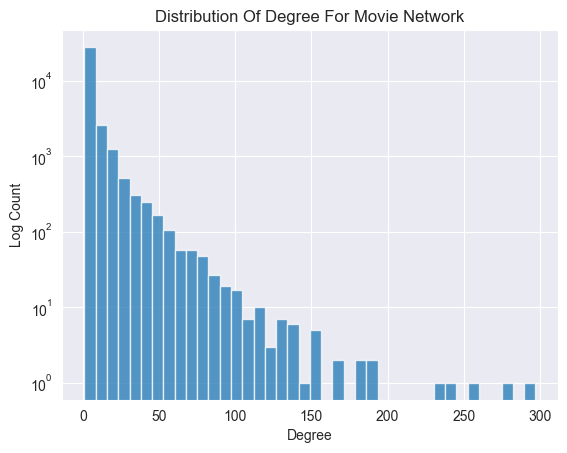

In [120]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

### Community detection

In [121]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [122]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [123]:
communities = louvain_partitions(G)
len(communities)

2755

In [124]:
modularity(G, communities) 

0.7960832977838771

Counter({2: 2035,
         3: 405,
         4: 123,
         5: 43,
         6: 34,
         7: 19,
         8: 11,
         12: 6,
         9: 5,
         10: 4,
         22: 3,
         11: 3,
         16: 3,
         118: 2,
         19: 2,
         15: 2,
         13: 2,
         23: 2,
         21: 2,
         582: 1,
         2602: 1,
         662: 1,
         719: 1,
         2597: 1,
         192: 1,
         1729: 1,
         2346: 1,
         734: 1,
         2116: 1,
         691: 1,
         2620: 1,
         709: 1,
         77: 1,
         964: 1,
         319: 1,
         320: 1,
         150: 1,
         308: 1,
         126: 1,
         878: 1,
         148: 1,
         623: 1,
         48: 1,
         119: 1,
         695: 1,
         720: 1,
         268: 1,
         54: 1,
         213: 1,
         212: 1,
         14: 1,
         868: 1,
         43: 1,
         112: 1,
         146: 1,
         30: 1,
         31: 1,
         45: 1,
         49: 1,
         37: 1,

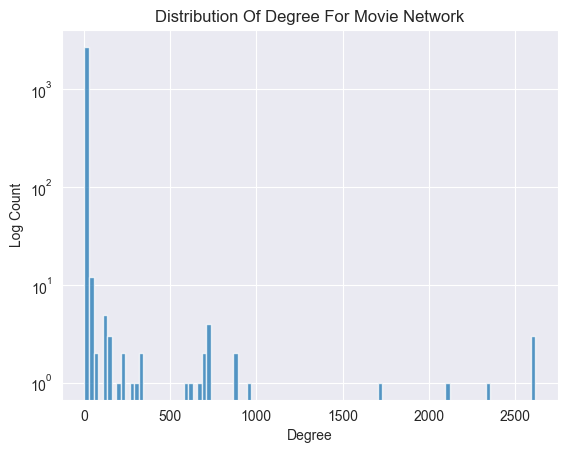

In [125]:
X = list(map(len, communities))
# X = [x for x in X if x < 100]
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

### Text analysis

In [126]:
all_asin = [asin for com in communities for asin in com]

In [127]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community
str,str,str,f64,i64,str,f64,f64,list[str],i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd_great"", ""stay_home"", … ""give""]",10
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife_daughter"", ""love"", … ""famili_movi""]",8
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21


In [128]:
filtered_df.filter(pl.col("community").is_null()).height

0

In [129]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null())

In [130]:
sum(list(map(len, communities))), len(G.nodes)

(33336, 33336)

In [131]:
# Tokenize and stemming reviews
stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

In [132]:
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenize(x) for x in filtered_df["text"]))
)

In [133]:
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community
str,str,str,f64,i64,str,f64,f64,list[str],i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd"", ""great"", … ""give""]",10
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife"", ""daughter"", … ""movi""]",8
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21


In [147]:
filtered_df = filtered_df.with_columns(
    pl.Series("bigrams", [list(nltk_bigrams(tokens)) for tokens in filtered_df["tokens"]])
)

In [148]:
filtered_df.write_json("tokenizedReviews.json")
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community,bigrams
str,str,str,f64,i64,str,f64,f64,list[str],i64,list[list[str]]
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd"", ""great"", … ""give""]",10,"[[""dvd"", ""great""], [""great"", ""stay""], … [""love"", ""give""]]"
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12,"[[""grew"", ""one""], [""one"", ""couldnt""], … [""collect"", ""collect""]]"
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife"", ""daughter"", … ""movi""]",8,"[[""wife"", ""daughter""], [""daughter"", ""love""], … [""famili"", ""movi""]]"
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38,"[[""receiv"", ""yesterday""], [""yesterday"", ""chose""], … [""classic"", ""childhood""]]"
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21,"[[""subject"", ""movi""], [""movi"", ""review""], … [""attack"", ""opinion""]]"


In [149]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)
filtered_df = filtered_df.drop("bigrams")

In [ ]:
bigrams = (tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2)

In [151]:
bigram_counts = Counter(bigrams)
first_counts = Counter()
second_counts = Counter()
for (w1, w2), cnt in bigram_counts.items():
    first_counts[w1] += cnt
    second_counts[w2] += cnt

N = len(bigrams)
items = list(bigram_counts.items())
bgs, nii = zip(*items)
w1s, w2s = zip(*bgs)

f = np.fromiter((first_counts[w] for w in w1s), float)
s = np.fromiter((second_counts[w] for w in w2s), float)
o = np.array(nii, float)

nio = f - o
noi = s - o
noo = N - (o + nio + noi)

Eii = f * s / N
Eio = f * (N - s) / N
Eoi = (N - f) * s / N
Eoo = (N - f) * (N - s) / N

chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
p_vals = chi2.sf(chi2_vals, 1)

mask = (o > 50) & (p_vals < 0.001)
collocs = {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

In [152]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenizer.tokenize(tokens) for tokens in filtered_df["tokens"]))
)

In [153]:
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community
str,str,str,f64,i64,str,f64,f64,list[str],i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd_great"", ""stay_home"", … ""give""]",10
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife_daughter"", ""love"", … ""famili_movi""]",8
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21


In [154]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("count")
    ).sort("count")
)
community_docs.limit(5)

community,tokens,count
i64,list[str],u32
268,"[""pleas"", ""wish_avail"", … ""wast_money""]",6
2493,"[""cant_say"", ""enough"", … ""complet""]",6
320,"[""great_show"", ""get_disk"", … ""avail_dvd""]",6
53,"[""slow"", ""silli"", … ""match""]",6
1634,"[""good"", ""instal"", … ""williamson""]",6


In [155]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [156]:
idf = calculate_idf(community_docs)

In [157]:
idf

{'one': 0.14916934947705413,
 'love': 0.15352665484600983,
 'like': 0.15352665484600983,
 'dvd': 0.17337295121794052,
 'great': 0.214287748856447,
 'watch': 0.2259564926908245,
 'time': 0.2473096171613934,
 'get': 0.2521173187294965,
 'show': 0.2715826535175999,
 'good': 0.2740426793584622,
 'enjoy': 0.29645955827300435,
 'well': 0.31424909983650273,
 'br': 0.3193904993369214,
 'even': 0.35346981298978397,
 'use': 0.3615019846870483,
 'also': 0.37231290079126383,
 'make': 0.3804984853777033,
 'seri': 0.3832419713234541,
 'way': 0.38599300469534403,
 'see': 0.38875162713442374,
 'go': 0.39429180751003917,
 'much': 0.4139277820268981,
 'look': 0.41960961549432896,
 'littl': 0.4253239167577677,
 'set': 0.4310710590133356,
 'play': 0.436851421928835,
 'first': 0.4543957315797446,
 'want': 0.4543957315797446,
 'better': 0.4543957315797446,
 'still': 0.4573499434771761,
 'think': 0.4573499434771761,
 'come': 0.4603129086078332,
 'best': 0.4603129086078332,
 'lot': 0.46328467899699055,
 'find